#  Predicting taxi orders

**Target**:
predict the number of taxi orders for the next hour

**Data Description**:
Historical data on taxi orders at airports.

**Model Quality Metric**:
RMSE

In [3]:
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


## Data preprocessing

In [4]:
data = pd.read_csv('/Users/alexey_zalesov/Desktop/ya_prakrikum/ds/datasets/taxi.csv',
                   index_col=[0], parse_dates=[0] )

display(data.head())
data.info()
data.describe()





,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Check for monotonicity of the date-time index:

In [5]:
print(data.index.is_monotonic)




True


### Summary
The index is monotonous, there are no gaps, so we can start data analysis and further division into samples

Resampling:

In [6]:
print(type(data))
print(len(data))

data = data.resample('1H').sum()

print(type(data))
print(len(data))



<class 'pandas.core.frame.DataFrame'>
26496
<class 'pandas.core.frame.DataFrame'>
4416


In [7]:
display(data['num_orders'])
print(min(data['num_orders']))

datetime
2018-03-01 00:00:00    124
2018-03-01 01:00:00     85
2018-03-01 02:00:00     71
2018-03-01 03:00:00     66
2018-03-01 04:00:00     43
                      ... 
2018-08-31 19:00:00    136
2018-08-31 20:00:00    154
2018-08-31 21:00:00    159
2018-08-31 22:00:00    223
2018-08-31 23:00:00    205
Freq: H, Name: num_orders, Length: 4416, dtype: int64

0


## Exploratory data analysis

A total of 4416 hours is 184 days and approximately 6 months. Let's look at the histogram, median and average of all data, for a month and a day.

Среднее арифметическое за все время 84.42278079710145
Медиана за все время 78.0


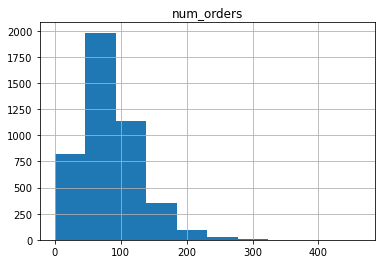

In [8]:
data.hist()

print('Среднее арифметическое за все время' , data['num_orders'].mean())
print('Медиана за все время', data['num_orders'].median())


array([[<AxesSubplot:title={'center':'num_orders'}>]], dtype=object)

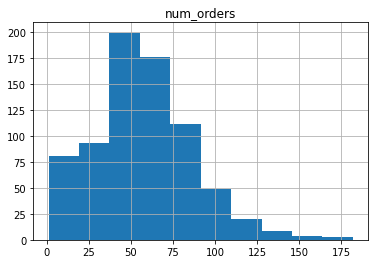

In [9]:
data_month = data['2018-03-01':'2018-03-31']
data_month.hist()

In [10]:
print('Среднее арифметическое за март', data_month['num_orders'].mean())
print('Медиана за март', data_month['num_orders'].median())

Среднее арифметическое за март 57.483870967741936
Медиана за март 55.0


array([[<AxesSubplot:title={'center':'num_orders'}>]], dtype=object)

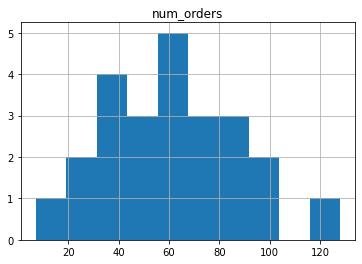

In [11]:
data_day = data['2018-03-31']
data_day.hist()

In [12]:
print('Среднее арифметическое за 31 марта', data_day['num_orders'].mean())
print('Медиана за 31 марта', data_day['num_orders'].median())

Среднее арифметическое за 31 марта 60.416666666666664
Медиана за 31 марта 60.5


In [13]:
decomposed = seasonal_decompose(data)

<AxesSubplot:xlabel='datetime'>

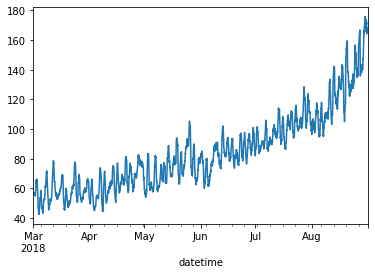

In [14]:
decomposed.trend.plot(ax = plt.gca())

The trend shows an increase and a change in the standard deviation, so it is not stationary.

<AxesSubplot:xlabel='datetime'>

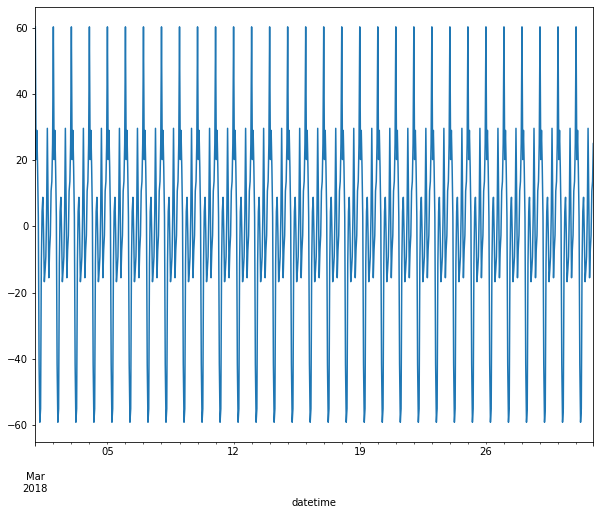

In [15]:
decomposed.seasonal['2018-03-01':'2018-03-31'].plot(ax = plt.gca(), figsize=(10,8))

<AxesSubplot:xlabel='datetime'>

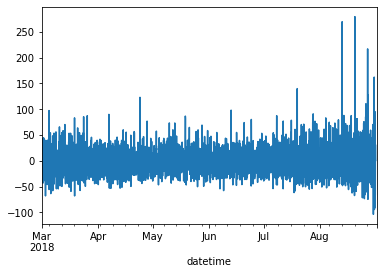

In [16]:
decomposed.resid.plot(ax = plt.gca())

## Fitting model

Let's add the data with features: calendar day, remaining and moving average)

Calendar (month, day of the week, hour, year, it makes no sense to add - we have one year):

In [17]:
#data['month'] = data.index.month
#data['day'] = data.index.day

In [18]:
data['dayofweek'] = data.index.dayofweek
data['hour'] = data.index.hour
display(data.head())

,num_orders,dayofweek,hour
datetime,,,
2018-03-01 00:00:00,124,3,0
2018-03-01 01:00:00,85,3,1
2018-03-01 02:00:00,71,3,2
2018-03-01 03:00:00,66,3,3
2018-03-01 04:00:00,43,3,4


Lag features:

In [19]:
def lag_features(data, max_lag, rolling_mean_size):    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()



In [20]:
#попробуем с такими значениями, в дальнейшем, возможно, придется экспериментально подобрать другие

lag_features(data, 2, 10)

In [21]:
display(data.head(20))

,num_orders,dayofweek,hour,lag_1,lag_2,rolling_mean
datetime,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,NaN
2018-03-01 05:00:00,6,3,5,43.0,66.0,NaN
2018-03-01 06:00:00,12,3,6,6.0,43.0,NaN
2018-03-01 07:00:00,15,3,7,12.0,6.0,NaN
2018-03-01 08:00:00,34,3,8,15.0,12.0,NaN


In [22]:
#удаляем пропущенные значения

data.dropna(inplace=True)

In [23]:
data.head()

,num_orders,dayofweek,hour,lag_1,lag_2,rolling_mean
datetime,,,,,,
2018-03-01 10:00:00,64,3,10,69.0,34.0,52.5
2018-03-01 11:00:00,96,3,11,64.0,69.0,46.5
2018-03-01 12:00:00,30,3,12,96.0,64.0,47.6
2018-03-01 13:00:00,32,3,13,30.0,96.0,43.5
2018-03-01 14:00:00,48,3,14,32.0,30.0,40.1


Let's divide the data into training, validation and test samples in the ratio 80:10:10

In [24]:
train_valid, test = train_test_split(data, shuffle=False, test_size=0.1)

In [25]:
train, valid = train_test_split(train_valid, shuffle=False, test_size=0.1)



In [26]:
print(len(train), len(valid), len(test))

3568 397 441


In [27]:
train.index.is_monotonic

True

In [28]:
valid.index.is_monotonic

True

In [29]:
test.index.is_monotonic

True

In [30]:
train.tail()

,num_orders,dayofweek,hour,lag_1,lag_2,rolling_mean
datetime,,,,,,
2018-07-27 21:00:00,133,4,21,131.0,86.0,116.1
2018-07-27 22:00:00,213,4,22,133.0,131.0,118.4
2018-07-27 23:00:00,122,4,23,213.0,133.0,127.9
2018-07-28 00:00:00,192,5,0,122.0,213.0,125.7
2018-07-28 01:00:00,195,5,1,192.0,122.0,138.8


In [31]:
valid.head()

,num_orders,dayofweek,hour,lag_1,lag_2,rolling_mean
datetime,,,,,,
2018-07-28 02:00:00,145,5,2,195.0,192.0,147.0
2018-07-28 03:00:00,132,5,3,145.0,195.0,145.3
2018-07-28 04:00:00,215,5,4,132.0,145.0,142.5
2018-07-28 05:00:00,91,5,5,215.0,132.0,156.4
2018-07-28 06:00:00,44,5,6,91.0,215.0,156.9


In [32]:
valid.tail()

,num_orders,dayofweek,hour,lag_1,lag_2,rolling_mean
datetime,,,,,,
2018-08-13 10:00:00,156,0,10,137.0,91.0,159.7
2018-08-13 11:00:00,144,0,11,156.0,137.0,159.3
2018-08-13 12:00:00,92,0,12,144.0,156.0,146.4
2018-08-13 13:00:00,119,0,13,92.0,144.0,111.9
2018-08-13 14:00:00,102,0,14,119.0,92.0,107.0


In [33]:
test.head()

,num_orders,dayofweek,hour,lag_1,lag_2,rolling_mean
datetime,,,,,,
2018-08-13 15:00:00,175,0,15,102.0,119.0,102.9
2018-08-13 16:00:00,144,0,16,175.0,102.0,112.1
2018-08-13 17:00:00,152,0,17,144.0,175.0,119.9
2018-08-13 18:00:00,104,0,18,152.0,144.0,131.2
2018-08-13 19:00:00,91,0,19,104.0,152.0,132.5


Sampling went well

In [34]:
train_features = train.drop('num_orders', axis=1)
train_target = train['num_orders']

In [35]:
valid_features = valid.drop('num_orders', axis=1)
valid_target = valid['num_orders']

In [36]:
test_features = test.drop('num_orders', axis=1)
test_target = test['num_orders']

Let's start testing models: try linear regression, random forest

In [37]:
def best_model(model):
    model.fit(train_features, train_target)
    predictions = model.predict(valid_features)
    
    score = mean_squared_error(valid_target, predictions)**0.5
    print('Модель:', model,'Значение метрики RMSE:', score)

In [38]:
model_LR = LinearRegression()

In [39]:
best_model(model_LR)

Модель: LinearRegression() Значение метрики RMSE: 42.69286247123915


Let's start fitting hyperparameters for Random Forest:


In [40]:
#depths={}


#for depth in range(3,100):

#    model = RandomForestRegressor(n_jobs=-1, max_depth=depth,)
#    model.fit(train_features, train_target)
#    predictions = model.predict(valid_features)
    
#    score = mean_squared_error(valid_target, predictions)**0.5
#    depths.update({depth:score})


In [41]:
#best_depth = min(depths, key = depths.get)
#print(best_depth)

Best depth = 15

In [42]:
#n_estimators_dict = {}

#for n_estimator in range(7,200):
#    model = RandomForestRegressor(n_jobs=-1, max_depth=15, n_estimators=n_estimator)
#    
#    model.fit(train_features, train_target)
#    predictions = model.predict(valid_features)
#    
#    score = mean_squared_error(valid_target, predictions)**0.5
#    n_estimators_dict.update({n_estimator:score})

In [43]:
#best_number_of_estimators = min(n_estimators_dict, key = n_estimators_dict.get)
#print(best_number_of_estimators)

best_number_of_estimators = 24

In [44]:
#leaves = {}

#for min_leaves in range(2,20):
#    model = RandomForestRegressor(n_jobs=-1, max_depth=15, n_estimators=24, min_samples_split = min_leaves)
    
#    model.fit(train_features, train_target)
#    predictions = model.predict(valid_features)
    
#    score = mean_squared_error(valid_target, predictions)**0.5
#    leaves.update({min_leaves:score})

In [45]:
#best_split_number = min(leaves, key = leaves.get)
#print(best_split_number)

best_split_number = 7

Let's train the model on both samples: both on the training and on the validation, perhaps this will help improve the result.

In [46]:
train_valid_features = train_valid.drop('num_orders', axis=1)

In [47]:
train_valid_target = train_valid['num_orders']

In [48]:
depths={}


for depth in range(3,100):

    model = RandomForestRegressor(n_jobs=-1, max_depth=depth,)
    model.fit(train_valid_features, train_valid_target)
    predictions = model.predict(valid_features)
    
    score = mean_squared_error(valid_target, predictions)**0.5
    depths.update({depth:score})



In [49]:
best_depth = min(depths, key = depths.get)
print(best_depth)

40


In [50]:
n_estimators_dict = {}

for n_estimator in range(7,200):
    model = RandomForestRegressor(n_jobs=-1, max_depth=40, n_estimators=n_estimator)
    
    model.fit(train_features, train_target)
    predictions = model.predict(valid_features)
    
    score = mean_squared_error(valid_target, predictions)**0.5
    n_estimators_dict.update({n_estimator:score})

In [51]:
best_number_of_estimators = min(n_estimators_dict, key = n_estimators_dict.get)
print(best_number_of_estimators)

40


In [52]:
leaves = {}

for min_leaves in range(2,20):
    model = RandomForestRegressor(n_jobs=-1, max_depth=40, n_estimators=best_number_of_estimators, min_samples_split = min_leaves)
    
    model.fit(train_features, train_target)
    predictions = model.predict(valid_features)
    
    score = mean_squared_error(valid_target, predictions)**0.5
    leaves.update({min_leaves:score})

In [53]:
best_split_number = min(leaves, key = leaves.get)
print(best_split_number)

14


In [54]:
model_RF = RandomForestRegressor(n_jobs=-1, n_estimators = best_number_of_estimators, max_depth = best_depth,
                                 min_samples_split = best_split_number)

model_RF.fit(train_valid_features, train_valid_target)

predictions = model_RF.predict(test_features)

score = mean_squared_error(test_target, predictions)**0.5


print(score)



48.24538920632954


## Testing

Let's check the model for sanity - create a dummy model that will give out the median and calculate the RMSE value for such a "model".

In [55]:
dummy_predictions = np.ones(test_target.shape) * train_target.median()

print("RMSE дамми-модели на тестовой выборке:", mean_squared_error(test_target, dummy_predictions)**0.5)


RMSE дамми-модели на тестовой выборке: 89.48758132212734


Our model has been tested for adequacy successfully

## Graphs:

In [56]:
predictions_df = pd.DataFrame(predictions, index= test_target.index)

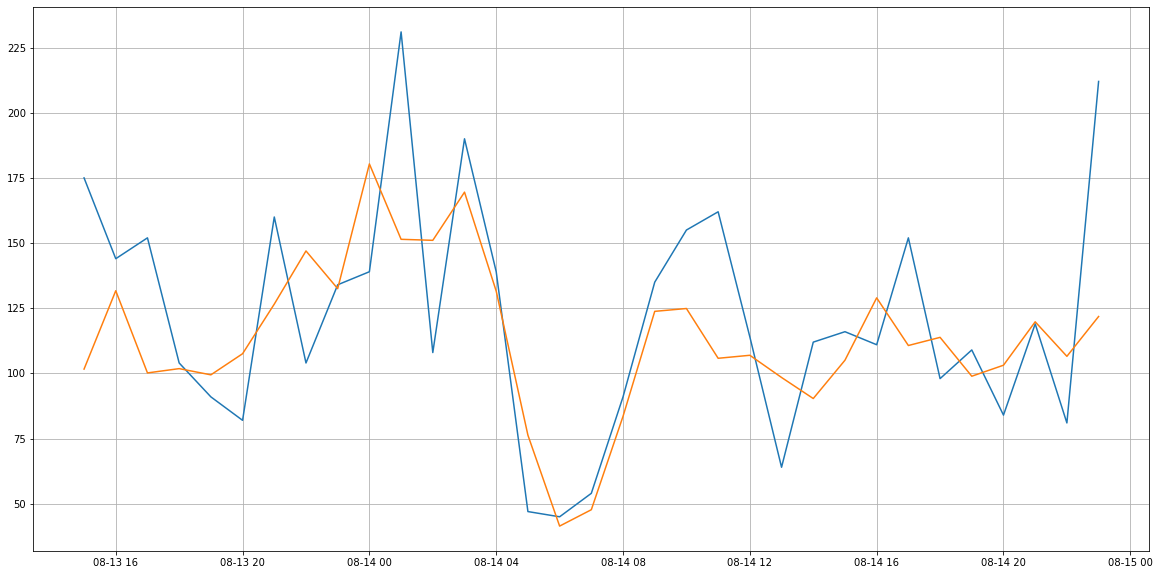

In [57]:
fig, ax = plt.subplots()

ax.plot(test_target['2018-08-13':'2018-08-14'])

ax.plot(predictions_df['2018-08-13':'2018-08-14'])

fig.set_size_inches(20,10)

ax.grid(True)

#test_target.plot(figsize=(15,10))
plt.show()



## Conclusion

The data was loaded, resampled, then the data was analyzed, additional features were prepared, and the final model with fitted hyperparameters showed an RMSE value of less than 48.